<a href="https://colab.research.google.com/github/ragi68/OpenWorld3D/blob/main/hw5_p3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Import PyTorch

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import random

import torch
import torch.nn as nn
device = 'cuda' if torch.cuda.is_available() else 'cpu'

torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

### Download and prepare the CIFAR10 dataset


The CIFAR10 dataset contains 60,000 color images in 10 classes, with 6,000 images in each class. The dataset is divided into 50,000 training images and 10,000 testing images. The classes are mutually exclusive and there is no overlap between them.

In [ ]:
from torchvision import datasets
from torchvision import transforms
transform = transforms.Compose([
    transforms.ToTensor(),
])
db_train = datasets.CIFAR10(root='./', train=True, transform=transform, download=True)
db_test = datasets.CIFAR10(root='./', train=False, transform=transform, download=True)
def subsample(db, n):
    idx = np.random.permutation(len(db))[:n]
    db.data = db.data[idx]
    db.targets = np.array(db.targets)[idx]
    return db

db_train = subsample(db_train, 5000)
db_test = subsample(db_test, 1000)

img, y = db_train[0]
print(img.shape, img.min(), img.max(), y)

100%|██████████| 170M/170M [00:14<00:00, 11.9MB/s]


torch.Size([3, 32, 32]) tensor(0.1412) tensor(0.9765) 7


### Verify the data

To verify that the dataset looks correct, let's plot the first 25 images from the training set and display the class name below each image.
Note that transforms.ToTensor transformed our image 32x32x3 image into a 3x32x32 tensor (the format that Conv2d layers expect).
However, to display the image, we need to permute its dimensions again.


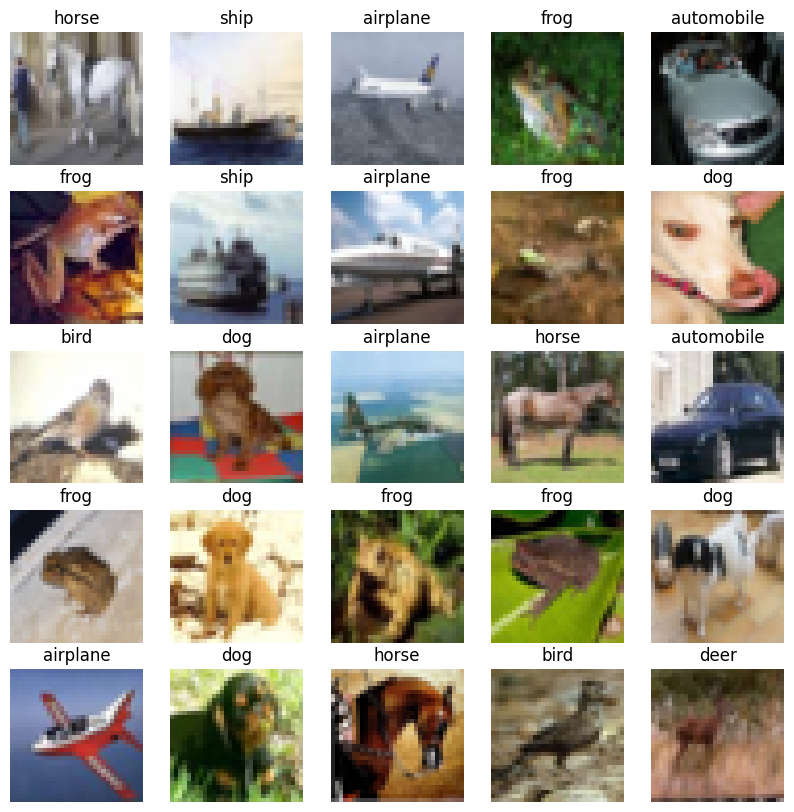

In [ ]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

plt.figure(figsize=(10,10))
for i in range(25):
    img, lbl = db_train[i]
    plt.subplot(5,5,i+1)
    plt.imshow(img.permute(1, 2, 0))
    plt.title(class_names[lbl])
    plt.axis(False)
plt.show()

### Create the convolutional base

The 6 lines of code below define the convolutional base using a common pattern: a stack of [Conv2D](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html) and [MaxPooling2D](https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html) layers.

As input, a CNN takes tensors of shape (image_height, image_width, color_channels), ignoring the batch size. If you are new to these dimensions, color_channels refers to (R,G,B). In this example, you will configure your CNN to process inputs of shape (32, 32, 3), which is the format of CIFAR images. You can do this by passing the argument `input_shape` to your first layer.


In [ ]:
model = nn.Sequential(
    nn.Conv2d(3, 32, kernel_size=(5, 5)),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2)),
    nn.Conv2d(32, 64, kernel_size=(3, 3)),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2)),
    nn.Conv2d(64, 64, kernel_size=(3, 3)),
    nn.ReLU(),
    nn.Flatten(),
    nn.Linear(1024, 10)
)

Here's the complete architecture of your model:

In [ ]:
print(model)

Sequential(
  (0): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (7): ReLU()
  (8): Flatten(start_dim=1, end_dim=-1)
  (9): Linear(in_features=1024, out_features=10, bias=True)
)


### Train the model

In [ ]:
from torch.utils.data import DataLoader
import tqdm

def init_weights(model):
    for m in model.modules():
        if isinstance(m, (nn.Conv2d, nn.Linear)):
            nn.init.normal_(m.weight, mean=0, std=0.005)

def accuracy(pred, labels):
    return (pred.argmax(-1) == labels).float().mean()


@torch.no_grad()
def eval(model, loader):
    accuracies = []
    for images, labels in tqdm.tqdm(loader):
        # Prepare data
        images = images.to(device)
        labels = labels.to(device)

        # Compute predictions, loss and accuracy
        pred = model(images)
        acc = accuracy(pred, labels)
        accuracies.append(acc.detach().item())
    return np.mean(accuracies)

def fit_one_epoch(model, opt, loader):
    losses, accuracies = [], []
    for images, labels in tqdm.tqdm(loader):
        # Prepare data
        images = images.to(device)
        labels = labels.to(device)

        # Compute predictions, loss and accuracy
        pred = model(images)
        l = loss(pred, labels)
        acc = accuracy(pred, labels)

        # Compute gradients and update the model
        opt.zero_grad()
        l.backward()
        opt.step()

        losses.append(l.detach().item())
        accuracies.append(acc.detach().item())
    return np.mean(losses), np.mean(accuracies)


def fit(model, loader_train, loader_test, epochs=10):
    opt = torch.optim.Adam(model.parameters(), lr=0.0005)
    hist_tr_loss, hist_tr_acc, hist_te_acc = [], [], []
    for epoch in range(epochs):
        tr_l, tr_acc = fit_one_epoch(model, opt, loader_train)
        te_acc = eval(model, loader_test)

        print(f"Finished epoch {epoch} of {epochs}: Train Loss = {tr_l:.3f}   Train Acc = {tr_acc:.3f}   Test Acc = {te_acc:.3f}", flush=True)
        hist_tr_loss.append(tr_l)
        hist_tr_acc.append(tr_acc)
        hist_te_acc.append(te_acc)
    return hist_tr_loss, hist_tr_acc, hist_te_acc

loader_train = DataLoader(db_train, batch_size=64, shuffle=True, drop_last=True)
loader_test = DataLoader(db_test, batch_size=64, shuffle=False)
loss = nn.CrossEntropyLoss()
model = model.to(device)
init_weights(model)
hist_tr_loss, hist_tr_acc, hist_te_acc = fit(model, loader_train, loader_test, epochs=30)

100%|██████████| 16/16 [00:00<00:00, 116.39it/s]

Finished epoch 0 of 30: Train Loss = 2.295   Train Acc = 0.112   Test Acc = 0.136



100%|██████████| 16/16 [00:00<00:00, 118.38it/s]

Finished epoch 1 of 30: Train Loss = 2.116   Train Acc = 0.203   Test Acc = 0.226



100%|██████████| 16/16 [00:00<00:00, 83.09it/s]

Finished epoch 2 of 30: Train Loss = 2.042   Train Acc = 0.231   Test Acc = 0.255



100%|██████████| 16/16 [00:00<00:00, 52.20it/s]

Finished epoch 3 of 30: Train Loss = 2.002   Train Acc = 0.266   Test Acc = 0.260



100%|██████████| 16/16 [00:00<00:00, 112.95it/s]

Finished epoch 4 of 30: Train Loss = 1.965   Train Acc = 0.274   Test Acc = 0.261



100%|██████████| 16/16 [00:00<00:00, 114.66it/s]

Finished epoch 5 of 30: Train Loss = 1.911   Train Acc = 0.292   Test Acc = 0.288



100%|██████████| 16/16 [00:00<00:00, 116.57it/s]

Finished epoch 6 of 30: Train Loss = 1.851   Train Acc = 0.323   Test Acc = 0.304



100%|██████████| 16/16 [00:00<00:00, 117.33it/s]

Finished epoch 7 of 30: Train Loss = 1.804   Train Acc = 0.342   Test Acc = 0.331



100%|██████████| 16/16 [00:00<00:00, 108.78it/s]

Finished epoch 8 of 30: Train Loss = 1.749   Train Acc = 0.357   Test Acc = 0.335



100%|██████████| 16/16 [00:00<00:00, 116.09it/s]

Finished epoch 9 of 30: Train Loss = 1.720   Train Acc = 0.375   Test Acc = 0.349



100%|██████████| 16/16 [00:00<00:00, 115.58it/s]

Finished epoch 10 of 30: Train Loss = 1.677   Train Acc = 0.381   Test Acc = 0.353



100%|██████████| 16/16 [00:00<00:00, 81.57it/s]

Finished epoch 11 of 30: Train Loss = 1.661   Train Acc = 0.392   Test Acc = 0.365



100%|██████████| 16/16 [00:00<00:00, 73.90it/s]

Finished epoch 12 of 30: Train Loss = 1.622   Train Acc = 0.407   Test Acc = 0.364



100%|██████████| 16/16 [00:00<00:00, 116.55it/s]

Finished epoch 13 of 30: Train Loss = 1.605   Train Acc = 0.416   Test Acc = 0.398



100%|██████████| 16/16 [00:00<00:00, 113.86it/s]

Finished epoch 14 of 30: Train Loss = 1.590   Train Acc = 0.417   Test Acc = 0.390



100%|██████████| 16/16 [00:00<00:00, 115.90it/s]

Finished epoch 15 of 30: Train Loss = 1.566   Train Acc = 0.439   Test Acc = 0.408



100%|██████████| 16/16 [00:00<00:00, 117.03it/s]

Finished epoch 16 of 30: Train Loss = 1.540   Train Acc = 0.445   Test Acc = 0.410



100%|██████████| 16/16 [00:00<00:00, 115.34it/s]

Finished epoch 17 of 30: Train Loss = 1.524   Train Acc = 0.453   Test Acc = 0.422



100%|██████████| 16/16 [00:00<00:00, 118.45it/s]

Finished epoch 18 of 30: Train Loss = 1.515   Train Acc = 0.451   Test Acc = 0.420



100%|██████████| 16/16 [00:00<00:00, 117.32it/s]

Finished epoch 19 of 30: Train Loss = 1.499   Train Acc = 0.461   Test Acc = 0.425



100%|██████████| 16/16 [00:00<00:00, 115.42it/s]

Finished epoch 20 of 30: Train Loss = 1.474   Train Acc = 0.469   Test Acc = 0.428



100%|██████████| 16/16 [00:00<00:00, 117.39it/s]

Finished epoch 21 of 30: Train Loss = 1.470   Train Acc = 0.473   Test Acc = 0.445



100%|██████████| 16/16 [00:00<00:00, 117.11it/s]

Finished epoch 22 of 30: Train Loss = 1.450   Train Acc = 0.482   Test Acc = 0.437



100%|██████████| 16/16 [00:00<00:00, 77.80it/s]

Finished epoch 23 of 30: Train Loss = 1.450   Train Acc = 0.478   Test Acc = 0.441



100%|██████████| 16/16 [00:00<00:00, 117.38it/s]

Finished epoch 24 of 30: Train Loss = 1.446   Train Acc = 0.478   Test Acc = 0.446



100%|██████████| 16/16 [00:00<00:00, 116.44it/s]

Finished epoch 25 of 30: Train Loss = 1.425   Train Acc = 0.491   Test Acc = 0.454



100%|██████████| 16/16 [00:00<00:00, 121.79it/s]

Finished epoch 26 of 30: Train Loss = 1.422   Train Acc = 0.491   Test Acc = 0.439



100%|██████████| 16/16 [00:00<00:00, 116.80it/s]

Finished epoch 27 of 30: Train Loss = 1.400   Train Acc = 0.503   Test Acc = 0.451



100%|██████████| 16/16 [00:00<00:00, 116.05it/s]

Finished epoch 28 of 30: Train Loss = 1.391   Train Acc = 0.500   Test Acc = 0.446



100%|██████████| 16/16 [00:00<00:00, 115.16it/s]

Finished epoch 29 of 30: Train Loss = 1.387   Train Acc = 0.503   Test Acc = 0.457


### Evaluate the model

100%|██████████| 16/16 [00:00<00:00, 80.10it/s]


Test accuracy: 45.72%


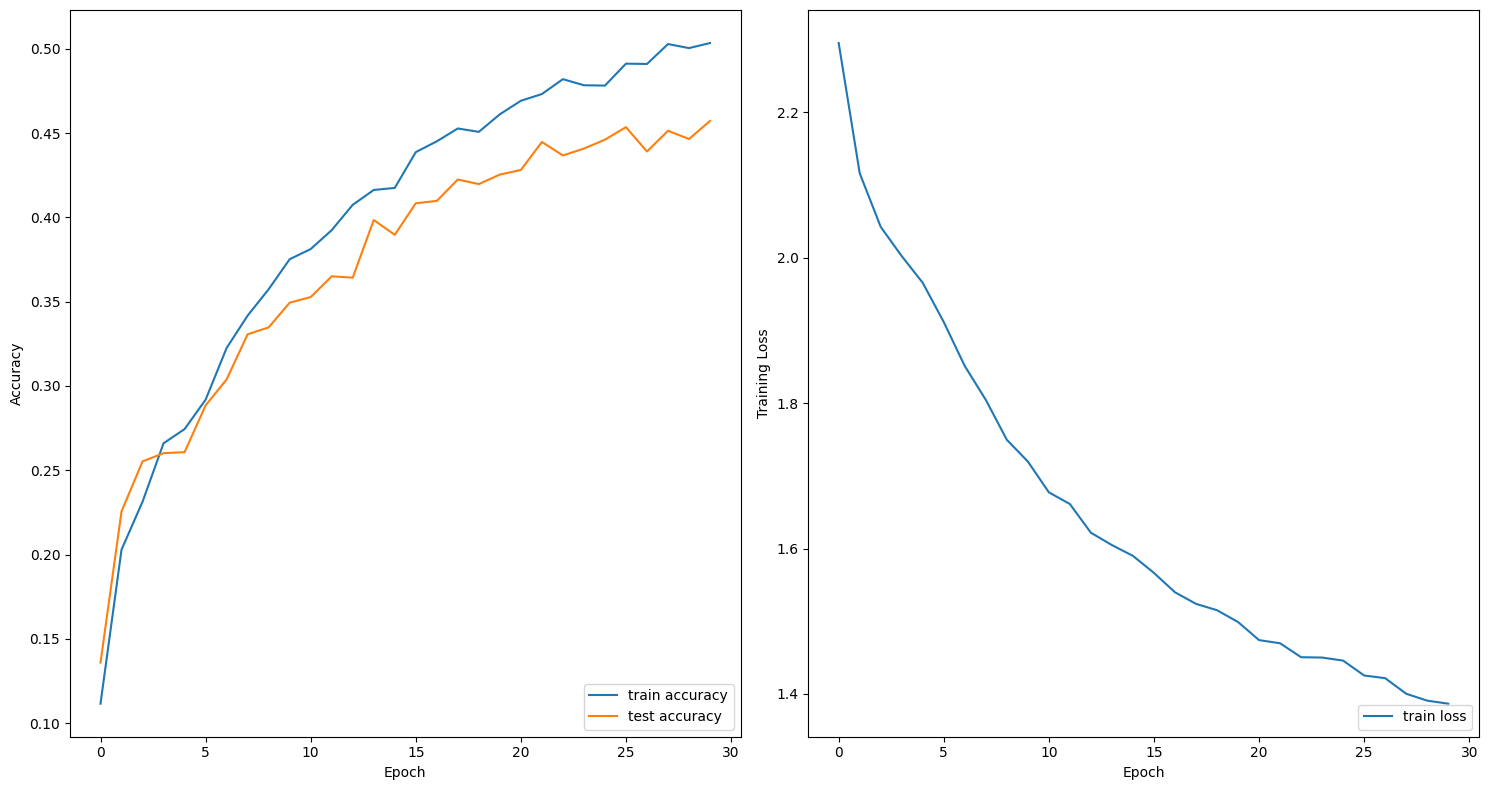

In [ ]:
plt.figure(figsize=(15,8))
plt.subplot(1, 2, 1)
plt.plot(hist_tr_acc, label='train accuracy')
plt.plot(hist_te_acc, label='test accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(hist_tr_loss, label='train loss')
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.legend(loc='lower right')
plt.tight_layout()

acc = eval(model, loader_test)
print(f'Test accuracy: {acc*100:.2f}%')

Now lets display a bunch of predictions of the model

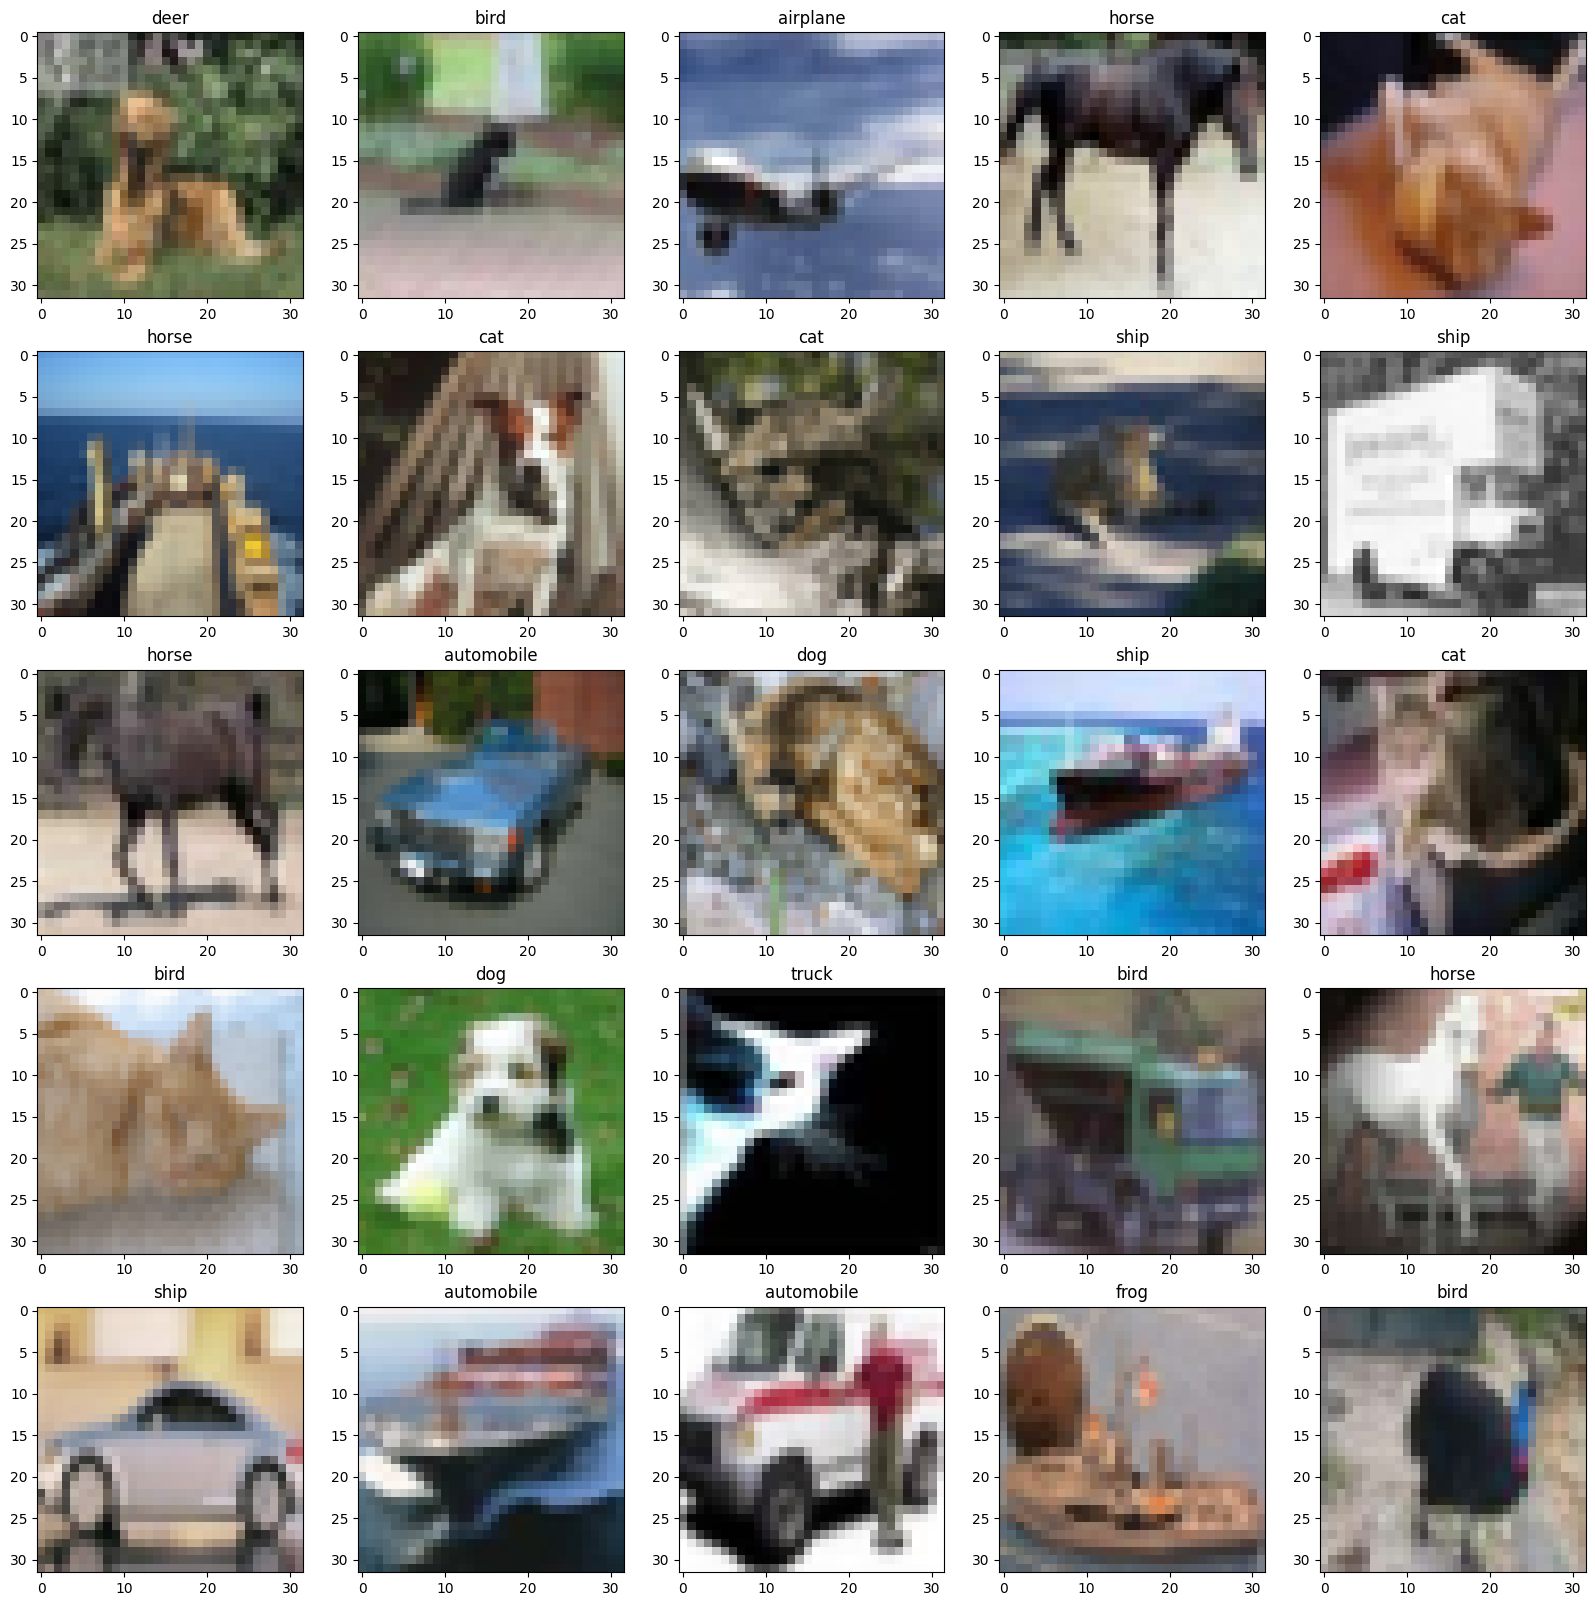

In [ ]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']
model = model.to(device)

plt.figure(figsize=(20,20))
for imgs, lbl in loader_test:
    with torch.no_grad():
        imgs = imgs.to(device)
        preds = model(imgs)
        preds = preds.argmax(1)
    for i in range(25):
        plt.subplot(5,5,i+1)
        plt.imshow(imgs[i].cpu().permute(1, 2, 0))
        plt.title(class_names[preds[i]])
plt.show()

# Batch Normalization
Typically, you would use PyTorch batch normalization class ([torch.nn.BatchNorm2D](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm2d.html)). However to gain an understanding of how batch norm works, we will implement our own. Complete the forward method of the MyBatchNorm class below. Recall that a batch norm layer performs two steps.
1. Normalizes the input x, by subtracting the mean and dividing by the standard deviation.
2. Outputs an affine transformation of the scaled input, i.e., x_out = alpha * x_norm + beta, where alpha and beta are trainable parameters of the model.

In [ ]:
class MyBatchNorm(nn.Module):
    def __init__(self, dims):
        super().__init__()
        self.eps = 1e-5
        self.alpha = nn.Parameter(torch.ones(1, dims, 1, 1))
        self.beta = nn.Parameter(torch.zeros(1, dims, 1, 1))

    def forward(self, x):
        # TODO
        mu = x.mean(dim=(0, 2, 3), keepdim=True)
        var = x.var(dim=(0, 2, 3), unbiased=False, keepdim=True)
        x_norm = (x - mu) / torch.sqrt(var + self.eps)
        x_out =  self.alpha * x_norm + self.beta
        return x_out

model = nn.Sequential(
    nn.Conv2d(3, 32, kernel_size=(5, 5)),
    MyBatchNorm(32),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2)),
    nn.Conv2d(32, 64, kernel_size=(3, 3)),
    MyBatchNorm(64),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2)),
    nn.Conv2d(64, 64, kernel_size=(3, 3)),
    MyBatchNorm(64),
    nn.ReLU(),
    nn.Flatten(),
    nn.Linear(1024, 10)
)

# Check the model
dummy_image = torch.randn(1, 3, 32, 32)
dummy_output = model(dummy_image)
print(f"{str(dummy_image.shape)} -> {str(dummy_output.shape)}")

torch.Size([1, 3, 32, 32]) -> torch.Size([1, 10])


100%|██████████| 16/16 [00:00<00:00, 109.12it/s]

Finished epoch 0 of 30: Train Loss = 1.763   Train Acc = 0.352   Test Acc = 0.435



100%|██████████| 16/16 [00:00<00:00, 109.48it/s]

Finished epoch 1 of 30: Train Loss = 1.426   Train Acc = 0.480   Test Acc = 0.470



100%|██████████| 16/16 [00:00<00:00, 112.16it/s]

Finished epoch 2 of 30: Train Loss = 1.277   Train Acc = 0.542   Test Acc = 0.540



100%|██████████| 16/16 [00:00<00:00, 98.13it/s]

Finished epoch 3 of 30: Train Loss = 1.140   Train Acc = 0.590   Test Acc = 0.521



100%|██████████| 16/16 [00:00<00:00, 109.98it/s]

Finished epoch 4 of 30: Train Loss = 1.061   Train Acc = 0.626   Test Acc = 0.582



100%|██████████| 16/16 [00:00<00:00, 108.27it/s]

Finished epoch 5 of 30: Train Loss = 0.960   Train Acc = 0.658   Test Acc = 0.538



100%|██████████| 16/16 [00:00<00:00, 106.44it/s]

Finished epoch 6 of 30: Train Loss = 0.884   Train Acc = 0.695   Test Acc = 0.609



100%|██████████| 16/16 [00:00<00:00, 78.64it/s]

Finished epoch 7 of 30: Train Loss = 0.788   Train Acc = 0.729   Test Acc = 0.605



100%|██████████| 16/16 [00:00<00:00, 95.40it/s]

Finished epoch 8 of 30: Train Loss = 0.725   Train Acc = 0.762   Test Acc = 0.594



100%|██████████| 16/16 [00:00<00:00, 109.92it/s]

Finished epoch 9 of 30: Train Loss = 0.667   Train Acc = 0.780   Test Acc = 0.599



100%|██████████| 16/16 [00:00<00:00, 105.65it/s]

Finished epoch 10 of 30: Train Loss = 0.597   Train Acc = 0.806   Test Acc = 0.589



100%|██████████| 16/16 [00:00<00:00, 107.49it/s]

Finished epoch 11 of 30: Train Loss = 0.542   Train Acc = 0.830   Test Acc = 0.602



100%|██████████| 16/16 [00:00<00:00, 108.27it/s]

Finished epoch 12 of 30: Train Loss = 0.480   Train Acc = 0.855   Test Acc = 0.627



100%|██████████| 16/16 [00:00<00:00, 109.74it/s]

Finished epoch 13 of 30: Train Loss = 0.437   Train Acc = 0.868   Test Acc = 0.584



100%|██████████| 16/16 [00:00<00:00, 111.27it/s]

Finished epoch 14 of 30: Train Loss = 0.380   Train Acc = 0.893   Test Acc = 0.622



100%|██████████| 16/16 [00:00<00:00, 106.44it/s]

Finished epoch 15 of 30: Train Loss = 0.326   Train Acc = 0.917   Test Acc = 0.599



100%|██████████| 16/16 [00:00<00:00, 93.76it/s]

Finished epoch 16 of 30: Train Loss = 0.275   Train Acc = 0.939   Test Acc = 0.616



100%|██████████| 16/16 [00:00<00:00, 110.81it/s]

Finished epoch 17 of 30: Train Loss = 0.234   Train Acc = 0.949   Test Acc = 0.618



100%|██████████| 16/16 [00:00<00:00, 105.21it/s]

Finished epoch 18 of 30: Train Loss = 0.206   Train Acc = 0.958   Test Acc = 0.622



100%|██████████| 16/16 [00:00<00:00, 111.55it/s]

Finished epoch 19 of 30: Train Loss = 0.169   Train Acc = 0.970   Test Acc = 0.605



100%|██████████| 16/16 [00:00<00:00, 112.01it/s]

Finished epoch 20 of 30: Train Loss = 0.147   Train Acc = 0.979   Test Acc = 0.607



100%|██████████| 16/16 [00:00<00:00, 107.04it/s]

Finished epoch 21 of 30: Train Loss = 0.127   Train Acc = 0.982   Test Acc = 0.614



100%|██████████| 16/16 [00:00<00:00, 110.34it/s]

Finished epoch 22 of 30: Train Loss = 0.115   Train Acc = 0.984   Test Acc = 0.623



100%|██████████| 16/16 [00:00<00:00, 112.82it/s]

Finished epoch 23 of 30: Train Loss = 0.089   Train Acc = 0.989   Test Acc = 0.619



100%|██████████| 16/16 [00:00<00:00, 110.16it/s]

Finished epoch 24 of 30: Train Loss = 0.074   Train Acc = 0.993   Test Acc = 0.627



100%|██████████| 16/16 [00:00<00:00, 110.97it/s]

Finished epoch 25 of 30: Train Loss = 0.070   Train Acc = 0.993   Test Acc = 0.630



100%|██████████| 16/16 [00:00<00:00, 69.70it/s]

Finished epoch 26 of 30: Train Loss = 0.059   Train Acc = 0.994   Test Acc = 0.625



100%|██████████| 16/16 [00:00<00:00, 108.29it/s]

Finished epoch 27 of 30: Train Loss = 0.043   Train Acc = 0.999   Test Acc = 0.616



100%|██████████| 16/16 [00:00<00:00, 106.21it/s]

Finished epoch 28 of 30: Train Loss = 0.033   Train Acc = 0.999   Test Acc = 0.627



100%|██████████| 16/16 [00:00<00:00, 103.57it/s]

Finished epoch 29 of 30: Train Loss = 0.034   Train Acc = 0.999   Test Acc = 0.623



100%|██████████| 16/16 [00:00<00:00, 98.85it/s] 


Test accuracy: 62.34%


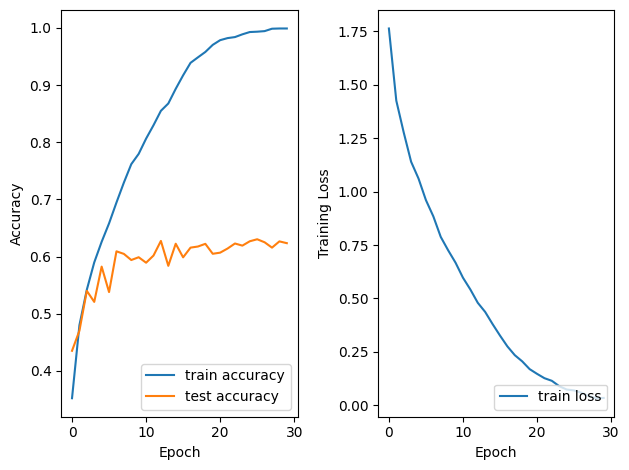

In [ ]:
# Train the model
init_weights(model)
model = model.to(device)
hist_tr_loss, hist_tr_acc, hist_te_acc = fit(model, loader_train, loader_test, epochs=30)

# Plot training history
plt.subplot(1, 2, 1)
plt.plot(hist_tr_acc, label='train accuracy')
plt.plot(hist_te_acc, label='test accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
# plt.ylim([0.3, 1])
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(hist_tr_loss, label='train loss')
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.legend(loc='lower right')
plt.tight_layout()

# Evaluate
acc = eval(model, loader_test)
print(f'Test accuracy: {acc*100:.2f}%')

(a) The training model did overfit the data. It went up to 1.0 on the training data yet converged around 0.6  on test accuracy. showing that it overfit for the training data. However, despite this, this model has better accuracy than the original model.

# Data augmentation
Lets now try some data augmentation techniques. The following code vizualizes four different types of data augmentations. What do each of them do?

Transform 1


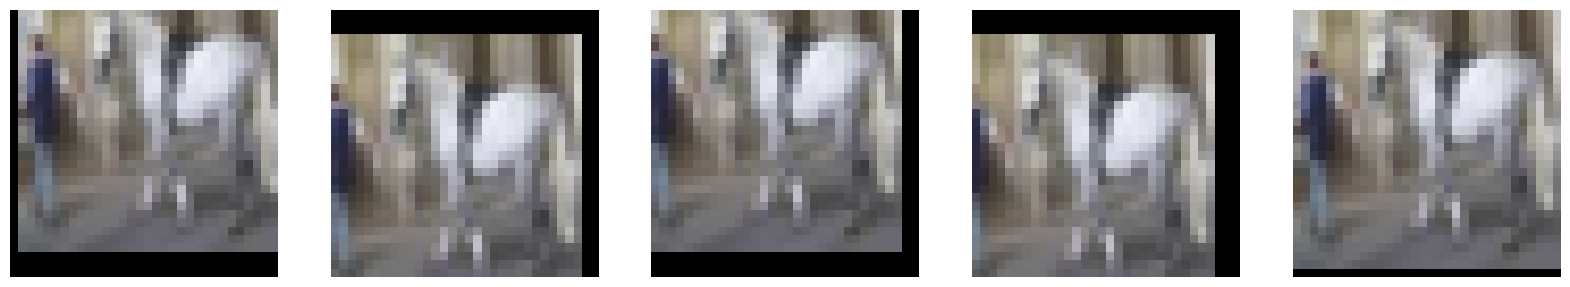

Transform 2


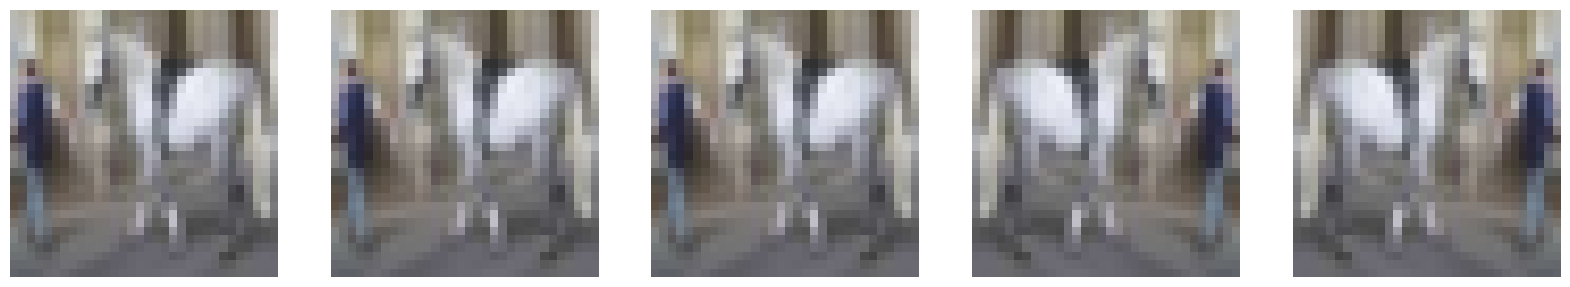

Transform 3


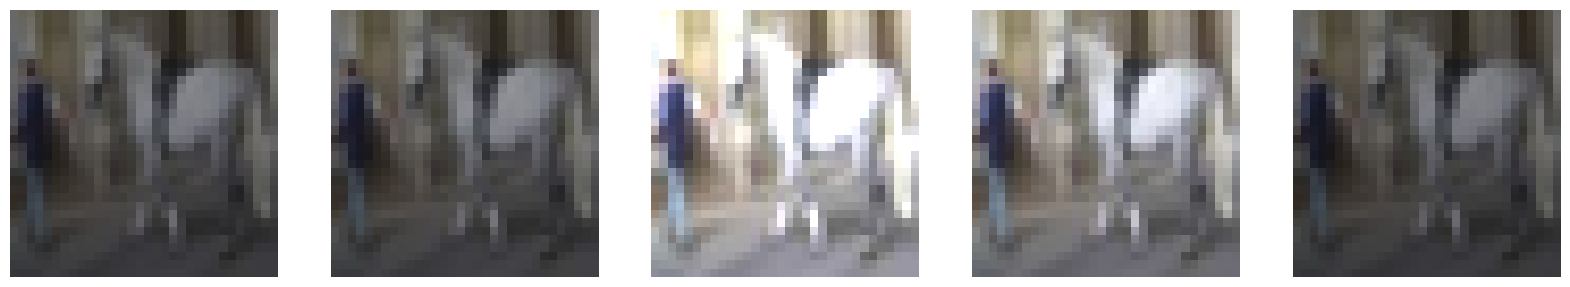

Transform 4


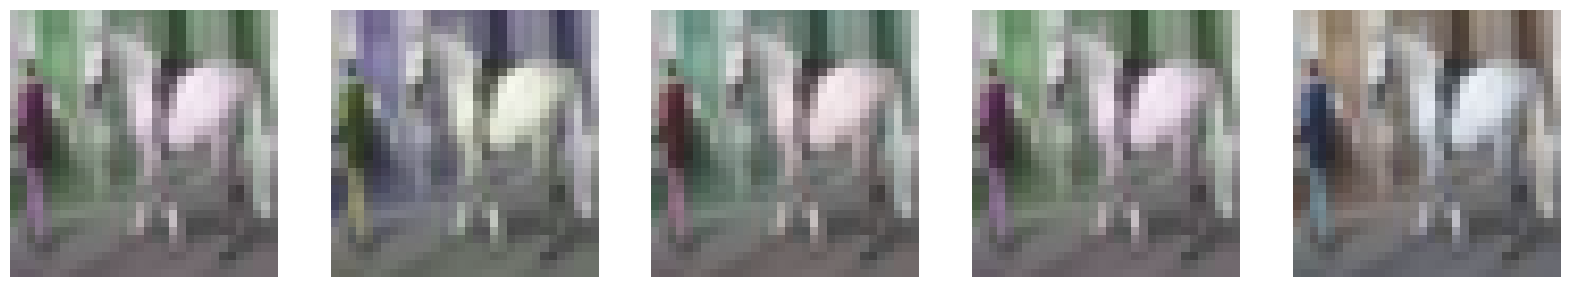

In [ ]:
def display_transform(transform, image_idx=10):
    # The CIFAR dataset uses db.transform to transform each image.
    # We can change the data augmentation by assigning our new transformation to this variable.
    # See __getitem__ in https://pytorch.org/vision/stable/_modules/torchvision/datasets/cifar.html#CIFAR10 for how db.transform is used.
    db_train.transform = transform
    plt.figure(figsize=(20,6))
    for i in range(5):
        img, lbl = db_train[image_idx]
        plt.subplot(1,5,1+i)
        plt.imshow(img.permute(1, 2, 0))
        plt.axis(False)
    plt.show()

print("Transform 1")
transform1 = transforms.Compose([
    transforms.RandomCrop(size=[32,32], padding=3),
    transforms.ToTensor()
])
display_transform(transform1, image_idx=0)

print("Transform 2")
transform2 = transforms.Compose([
    transforms.RandomHorizontalFlip(0.5),
    transforms.ToTensor()
])
display_transform(transform2, image_idx=0)

print("Transform 3")
transform3 = transforms.Compose([
    transforms.ColorJitter(brightness=0.5),
    transforms.ToTensor()
])
display_transform(transform3, image_idx=0)

print("Transform 4")
transform4 = transforms.Compose([
    transforms.ColorJitter(hue=0.5),
    transforms.ToTensor()
])
display_transform(transform4, image_idx=0)

Lets now train a new model (with batch normalization) using data augmentation. Speficially we will augment our images in two ways. 1) Random crops by first padding the images on all sides with zeros followed by a random crop and 2) by randomly flipping the image with a 50% probability.

100%|██████████| 16/16 [00:00<00:00, 109.14it/s]

Finished epoch 0 of 30: Train Loss = 1.838   Train Acc = 0.293   Test Acc = 0.414



100%|██████████| 16/16 [00:00<00:00, 106.34it/s]

Finished epoch 1 of 30: Train Loss = 1.627   Train Acc = 0.388   Test Acc = 0.421



100%|██████████| 16/16 [00:00<00:00, 105.53it/s]

Finished epoch 2 of 30: Train Loss = 1.501   Train Acc = 0.453   Test Acc = 0.466



100%|██████████| 16/16 [00:00<00:00, 106.39it/s]

Finished epoch 3 of 30: Train Loss = 1.426   Train Acc = 0.482   Test Acc = 0.483



100%|██████████| 16/16 [00:00<00:00, 106.72it/s]

Finished epoch 4 of 30: Train Loss = 1.361   Train Acc = 0.498   Test Acc = 0.520



100%|██████████| 16/16 [00:00<00:00, 99.31it/s] 

Finished epoch 5 of 30: Train Loss = 1.300   Train Acc = 0.525   Test Acc = 0.548



100%|██████████| 16/16 [00:00<00:00, 106.62it/s]

Finished epoch 6 of 30: Train Loss = 1.276   Train Acc = 0.534   Test Acc = 0.549



100%|██████████| 16/16 [00:00<00:00, 105.55it/s]

Finished epoch 7 of 30: Train Loss = 1.221   Train Acc = 0.553   Test Acc = 0.584



100%|██████████| 16/16 [00:00<00:00, 74.04it/s]

Finished epoch 8 of 30: Train Loss = 1.160   Train Acc = 0.581   Test Acc = 0.586



100%|██████████| 16/16 [00:00<00:00, 106.17it/s]

Finished epoch 9 of 30: Train Loss = 1.160   Train Acc = 0.584   Test Acc = 0.580



100%|██████████| 16/16 [00:00<00:00, 108.32it/s]

Finished epoch 10 of 30: Train Loss = 1.135   Train Acc = 0.580   Test Acc = 0.617



100%|██████████| 16/16 [00:00<00:00, 104.78it/s]

Finished epoch 11 of 30: Train Loss = 1.079   Train Acc = 0.599   Test Acc = 0.588



100%|██████████| 16/16 [00:00<00:00, 105.68it/s]

Finished epoch 12 of 30: Train Loss = 1.066   Train Acc = 0.620   Test Acc = 0.622



100%|██████████| 16/16 [00:00<00:00, 100.38it/s]

Finished epoch 13 of 30: Train Loss = 1.035   Train Acc = 0.619   Test Acc = 0.623



100%|██████████| 16/16 [00:00<00:00, 69.85it/s]

Finished epoch 14 of 30: Train Loss = 1.000   Train Acc = 0.635   Test Acc = 0.620



100%|██████████| 16/16 [00:00<00:00, 96.35it/s]

Finished epoch 15 of 30: Train Loss = 0.991   Train Acc = 0.647   Test Acc = 0.640



100%|██████████| 16/16 [00:00<00:00, 103.28it/s]

Finished epoch 16 of 30: Train Loss = 0.974   Train Acc = 0.645   Test Acc = 0.620



100%|██████████| 16/16 [00:00<00:00, 111.04it/s]

Finished epoch 17 of 30: Train Loss = 0.966   Train Acc = 0.648   Test Acc = 0.641



100%|██████████| 16/16 [00:00<00:00, 109.38it/s]

Finished epoch 18 of 30: Train Loss = 0.938   Train Acc = 0.655   Test Acc = 0.646



100%|██████████| 16/16 [00:00<00:00, 108.15it/s]

Finished epoch 19 of 30: Train Loss = 0.917   Train Acc = 0.674   Test Acc = 0.637



100%|██████████| 16/16 [00:00<00:00, 75.45it/s]

Finished epoch 20 of 30: Train Loss = 0.920   Train Acc = 0.669   Test Acc = 0.647



100%|██████████| 16/16 [00:00<00:00, 88.40it/s]

Finished epoch 21 of 30: Train Loss = 0.884   Train Acc = 0.684   Test Acc = 0.658



100%|██████████| 16/16 [00:00<00:00, 109.17it/s]

Finished epoch 22 of 30: Train Loss = 0.884   Train Acc = 0.685   Test Acc = 0.671



100%|██████████| 16/16 [00:00<00:00, 107.10it/s]

Finished epoch 23 of 30: Train Loss = 0.867   Train Acc = 0.684   Test Acc = 0.666



100%|██████████| 16/16 [00:00<00:00, 99.90it/s]

Finished epoch 24 of 30: Train Loss = 0.850   Train Acc = 0.696   Test Acc = 0.671



100%|██████████| 16/16 [00:00<00:00, 107.09it/s]

Finished epoch 25 of 30: Train Loss = 0.839   Train Acc = 0.706   Test Acc = 0.674



100%|██████████| 16/16 [00:00<00:00, 85.88it/s]

Finished epoch 26 of 30: Train Loss = 0.831   Train Acc = 0.707   Test Acc = 0.673



100%|██████████| 16/16 [00:00<00:00, 108.72it/s]

Finished epoch 27 of 30: Train Loss = 0.807   Train Acc = 0.706   Test Acc = 0.672



100%|██████████| 16/16 [00:00<00:00, 105.98it/s]

Finished epoch 28 of 30: Train Loss = 0.798   Train Acc = 0.710   Test Acc = 0.671



100%|██████████| 16/16 [00:00<00:00, 104.78it/s]

Finished epoch 29 of 30: Train Loss = 0.776   Train Acc = 0.729   Test Acc = 0.674



100%|██████████| 16/16 [00:00<00:00, 105.28it/s]


Test accuracy: 67.40%


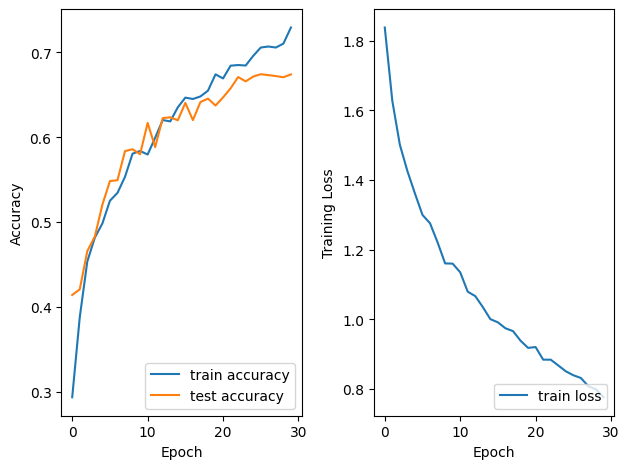

In [ ]:
# Define new transform
db_train.transform = transforms.Compose([
    # TODO
    transforms.RandomCrop(32, padding=4),      # 1) zero-pad + random crop
    transforms.RandomHorizontalFlip(p=0.5),    # 2) random flip
    transforms.ToTensor()
])

loader_train = DataLoader(db_train, batch_size=64, shuffle=True, drop_last=True)
loader_test = DataLoader(db_test, batch_size=64, shuffle=False)
loss = nn.CrossEntropyLoss()
init_weights(model)
hist_tr_loss, hist_tr_acc, hist_te_acc = fit(model, loader_train, loader_test, epochs=30)

# Plot training history
plt.subplot(1, 2, 1)
plt.plot(hist_tr_acc, label='train accuracy')
plt.plot(hist_te_acc, label='test accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
# plt.ylim([0.3, 1])
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(hist_tr_loss, label='train loss')
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.legend(loc='lower right')
plt.tight_layout()

# Evaluate
acc = eval(model, loader_test)
print(f'Test accuracy: {acc*100:.2f}%')

Comparative to the first part, the training accuracy is lower (70-80) but the accuracy has gone up (67-70). It's evident that doing image transformations reduce the overfitting the model does, and in doing so lowers training accuracy, but lets the model make generalizations better.